# Training strategies

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ds_functions as ds
from sklearn.model_selection import train_test_split

data: pd.DataFrame = pd.read_csv('datasets/heart_failure_clinical_records_dataset.csv')
target = 'DEATH_EVENT'
positive = 1
negative = 0
# print(data['DEATH_EVENT'].value_counts())
values = {'Original': [len(data[data[target] == positive]), len(data[data[target] == negative])]}
y: np.ndarray = data.pop('DEATH_EVENT').values
X: np.ndarray = data.values
labels: np.ndarray = pd.unique(y)

{'Original': [96, 203], 'Train': [67, 142], 'Test': [29, 61]}


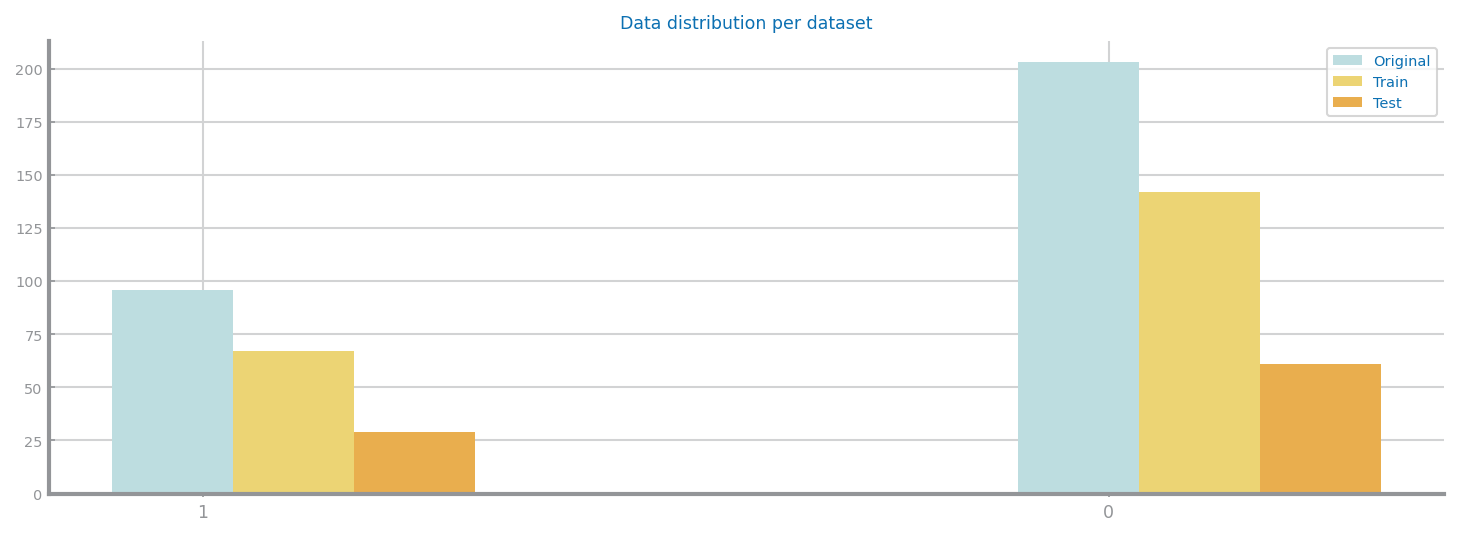

In [37]:
trnX, tstX, trnY, tstY = train_test_split(X, y, train_size=0.7, stratify=y)
values['Train'] = [len(np.delete(trnY, np.argwhere(trnY==negative))), len(np.delete(trnY, np.argwhere(trnY==positive)))]
values['Test'] = [len(np.delete(tstY, np.argwhere(tstY==negative))), len(np.delete(tstY, np.argwhere(tstY==positive)))]
plt.figure(figsize=(12,4))
print(values)
ds.multiple_bar_chart([positive, negative], values, title='Data distribution per dataset')
plt.show()

More than half of the are records are 0, making it slightly unbalanced. So in order to make it easier for the training we should balance the data.

# Scaling

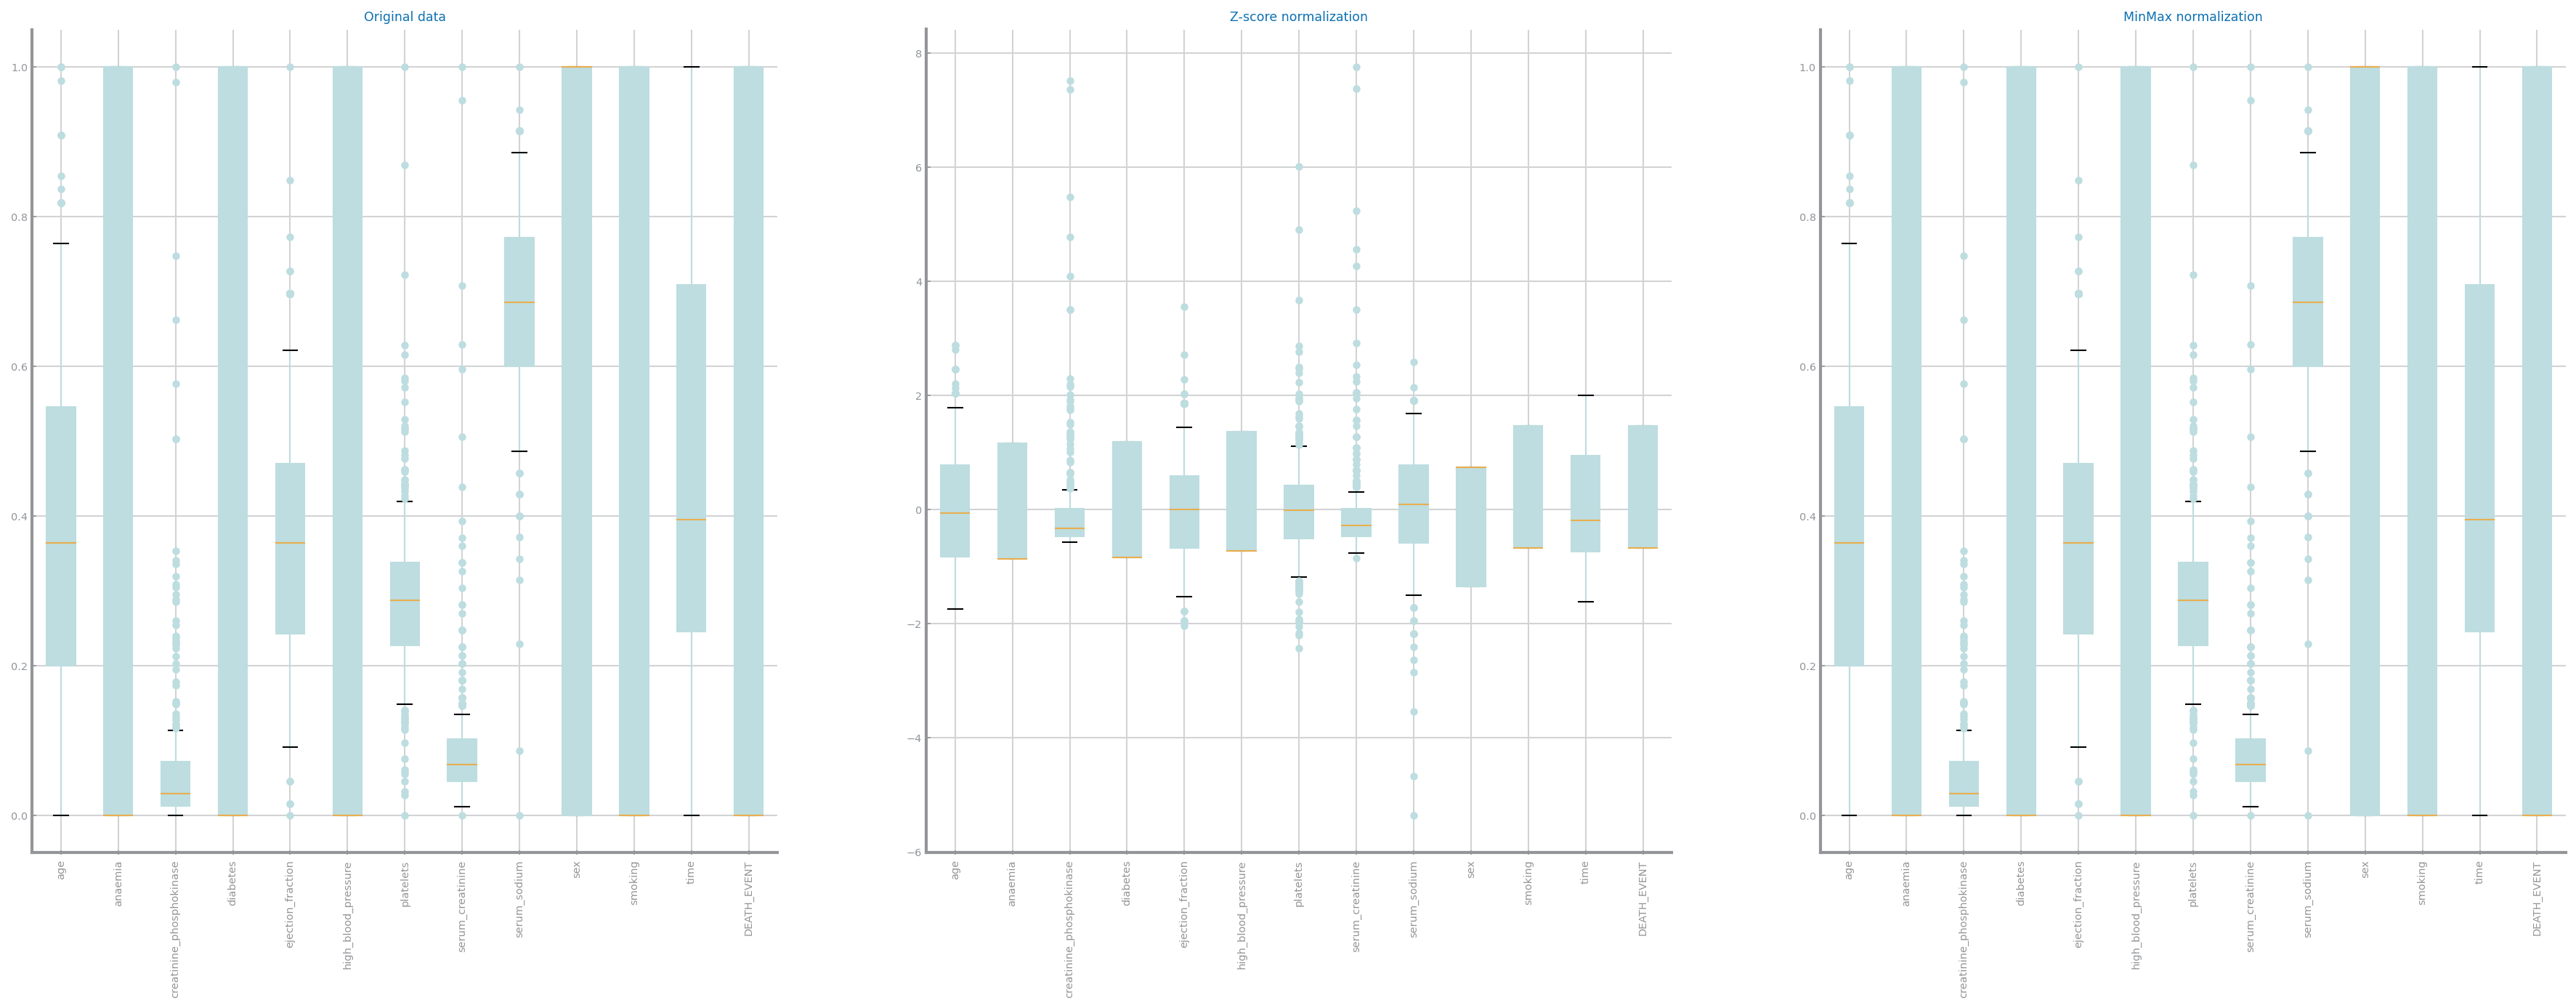

In [105]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

transf = StandardScaler(with_mean=True, with_std=True, copy=True).fit(data)
df_nr = pd.DataFrame(transf.transform(data), columns= data.columns)
norm_data_zscore = df_nr
norm_data_zscore.describe(include='all')

transf = MinMaxScaler(feature_range=(0, 1), copy=True).fit(df_nr)
df_nr = pd.DataFrame(transf.transform(df_nr), columns= df_nr.columns)
norm_data_minmax = df_nr
norm_data_minmax.describe(include='all')

import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 3, figsize=(30,10),squeeze=False )
axs[0, 0].set_title('Original data')
df_nr.boxplot(ax=axs[0, 0])
axs[0, 1].set_title('Z-score normalization')
norm_data_zscore.boxplot(ax=axs[0, 1])
axs[0, 2].set_title('MinMax normalization')
# axs[0, 2].xticks(rotation=90)
norm_data_minmax.boxplot(ax=axs[0, 2])
# fig.tight_layout()
for i in range(3):
    plt.setp(axs[0, i].xaxis.get_majorticklabels(), rotation=90)
    
plt.show()

In [124]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

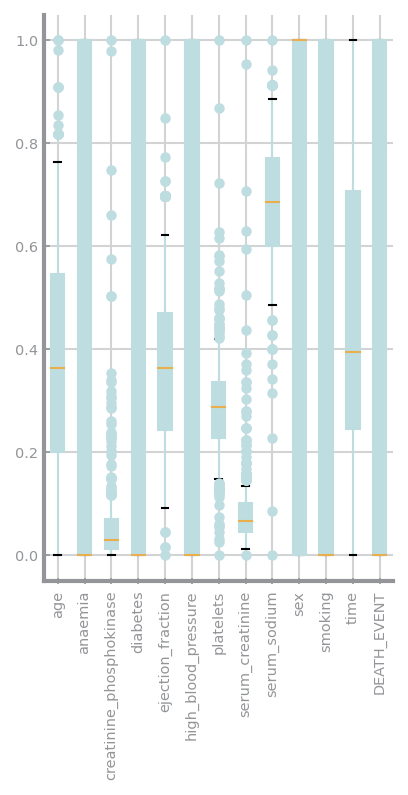

In [117]:
df_nr.boxplot(figsize=(3,5))
plt.xticks(rotation=90)
plt.show()

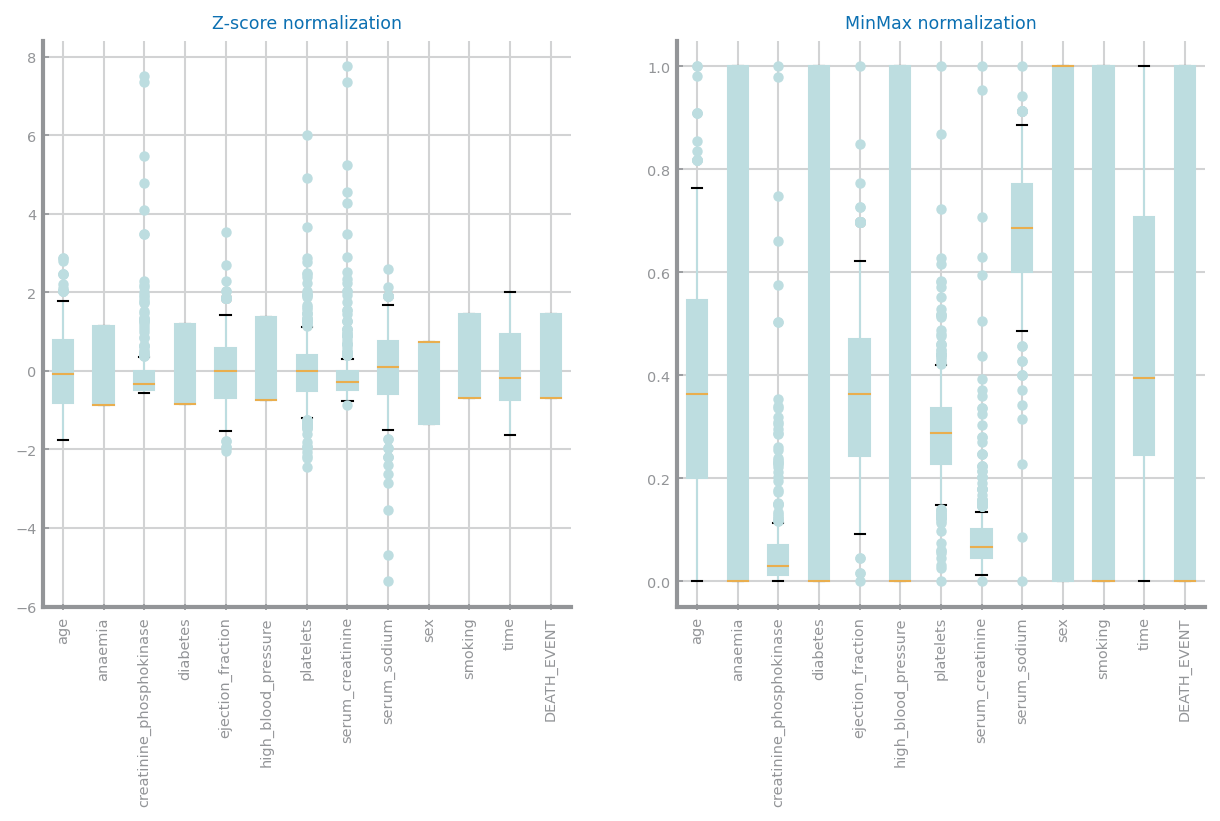

In [125]:
fig, axs = plt.subplots(1, 2, figsize=(10,5),squeeze=False )
axs[0, 0].set_title('Z-score normalization')
norm_data_zscore.boxplot(ax=axs[0, 0])
axs[0, 1].set_title('MinMax normalization')
# axs[0, 2].xticks(rotation=90)
norm_data_minmax.boxplot(ax=axs[0, 1])
# fig.tight_layout()
for i in range(2):
    plt.setp(axs[0, i].xaxis.get_majorticklabels(), rotation=90)
    
plt.show()

# Naive Bayes

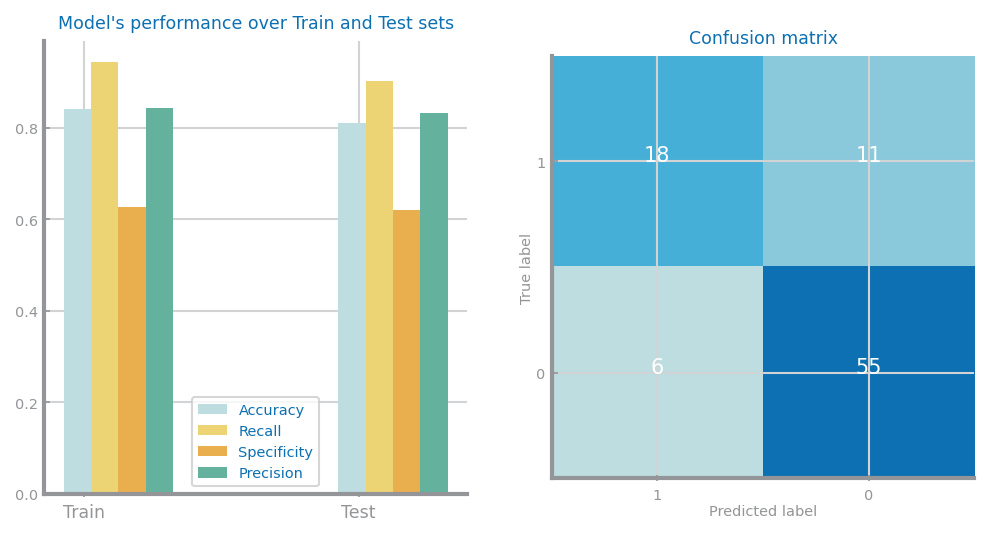

In [129]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
import ds_functions as ds

data: pd.DataFrame = pd.read_csv('datasets/heart_failure_clinical_records_dataset.csv')
y: np.ndarray = data.pop('DEATH_EVENT').values
X: np.ndarray = data.values
labels = pd.unique(y)

trnX, tstX, trnY, tstY = train_test_split(X, y, train_size=0.7, stratify=y)

clf = GaussianNB()
clf.fit(trnX, trnY)
prd_trn = clf.predict(trnX)
prd_tst = clf.predict(tstX)
ds.plot_evaluation_results(pd.unique(y), trnY, prd_trn, tstY, prd_tst)

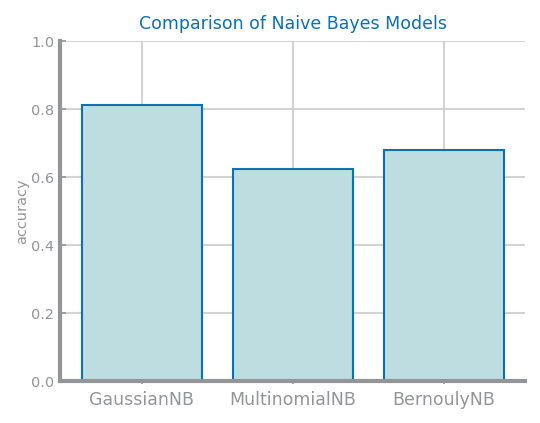

In [130]:
estimators = {'GaussianNB': GaussianNB(),
              'MultinomialNB': MultinomialNB(),
              'BernoulyNB': BernoulliNB()}

xvalues = []
yvalues = []
for clf in estimators:
    xvalues.append(clf)
    estimators[clf].fit(trnX, trnY)
    prdY = estimators[clf].predict(tstX)
    yvalues.append(metrics.accuracy_score(tstY, prdY))

plt.figure()
ds.bar_chart(xvalues, yvalues, title='Comparison of Naive Bayes Models', ylabel='accuracy', percentage=True)
plt.show()

# KNN

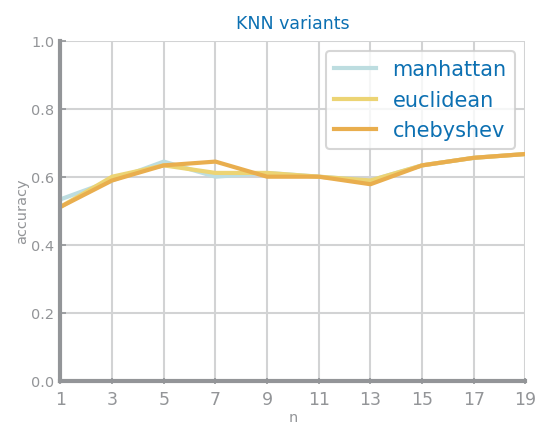

Best results with 19 neighbors and manhattan


In [155]:
import sklearn.metrics as metrics
from sklearn.neighbors import KNeighborsClassifier

labels = pd.unique(y)

trnX, tstX, trnY, tstY = train_test_split(X, y, train_size=0.7, stratify=y)

nvalues = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19]
dist = ['manhattan', 'euclidean', 'chebyshev']
values = {}
best = (0, '')
last_best = 0
for d in dist:
    yvalues = []
    for n in nvalues:
        knn = KNeighborsClassifier(n_neighbors=n, metric=d)
        knn.fit(trnX, trnY)
        prdY = knn.predict(tstX)
        yvalues.append(metrics.accuracy_score(tstY, prdY))
        if yvalues[-1] > last_best:
            best = (n, d)
            last_best = yvalues[-1]
    values[d] = yvalues

plt.figure()
ds.multiple_line_chart(nvalues, values, title='KNN variants', xlabel='n', ylabel='accuracy', percentage=True)
plt.show()
print('Best results with %d neighbors and %s'%(best[0], best[1]))

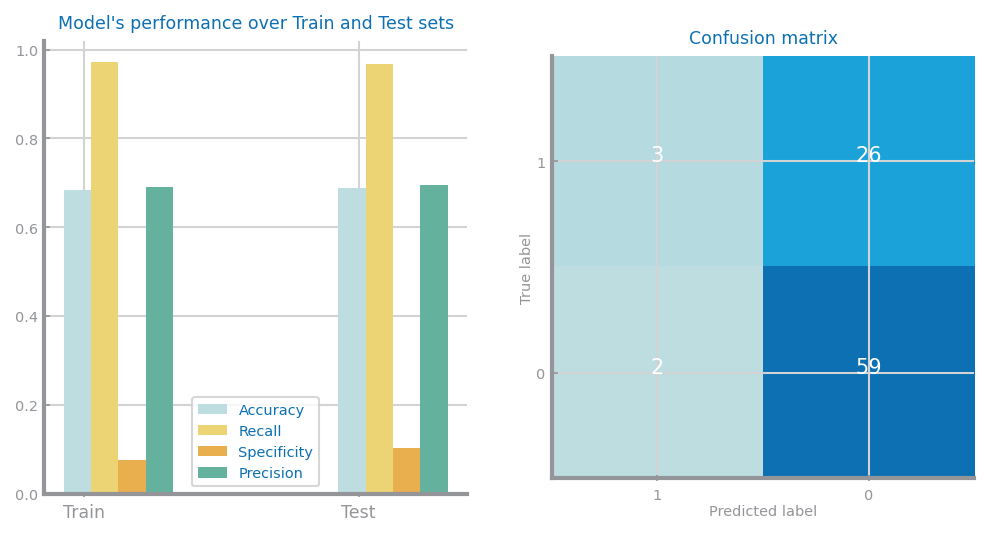

In [154]:
clf = knn = KNeighborsClassifier(n_neighbors=best[0], metric=best[1])
clf.fit(trnX, trnY)
prd_trn = clf.predict(trnX)
prd_tst = clf.predict(tstX)
ds.plot_evaluation_results(pd.unique(y), trnY, prd_trn, tstY, prd_tst)